In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ============================================
# MODELO DEMOGRÁFICO SIMPLIFICADO
# Solo Población: Crecimiento = (Nacimientos - Muertes) / 1000
# ============================================

DB_HOST = "localhost"
DB_DATABASE = "population_collapse"
DB_USER = "root"
DB_PASSWORD = "San@orca.1315"

connection = mysql.connector.connect(
    host=DB_HOST,
    database=DB_DATABASE,
    user=DB_USER,
    password=DB_PASSWORD
)

df_population = pd.read_sql("SELECT * FROM population", con=connection)
df_birth = pd.read_sql("SELECT * FROM birth_rate", con=connection)
df_fertility = pd.read_sql("SELECT * FROM fertility_rate", con=connection)
df_death = pd.read_sql("SELECT * FROM death_rate", con=connection)

country = "COL"
years = [col for col in df_population.columns if col.startswith("YR")]

# Extraer datos del país
country_pop = df_population[df_population["id"] == country].iloc[0]
country_birth_rate = df_birth[df_birth["id"] == country].iloc[0]
country_death_rate = df_death[df_death["id"] == country].iloc[0]

# Crear DataFrame consolidado
df_col = pd.DataFrame({
    "Year": [int(y.replace("YR", "")) for y in years],
    "Population": country_pop[years].values.astype(float),
    "BirthRate": country_birth_rate[years].values.astype(float),
    "DeathRate": country_death_rate[years].values.astype(float)
})

# Calcular tasa de crecimiento natural
df_col["Natural_Growth_Rate"] = (df_col["BirthRate"] - df_col["DeathRate"]) / 10

# Calcular crecimiento "normalizado" (sin COVID)
mortality_2019 = df_col[df_col["Year"] == 2019]["DeathRate"].values[0]

df_col

C:\Users\santi\AppData\Local\Temp\ipykernel_7788\4199355429.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_population = pd.read_sql("SELECT * FROM population", con=connection)
C:\Users\santi\AppData\Local\Temp\ipykernel_7788\4199355429.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_birth = pd.read_sql("SELECT * FROM birth_rate", con=connection)
C:\Users\santi\AppData\Local\Temp\ipykernel_7788\4199355429.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fertility = pd.read_sql("SELECT * FROM fertility

,Year,Population,BirthRate,DeathRate,Natural_Growth_Rate
0,2000,39215135.0,22.114,5.351,1.6763
1,2001,39837875.0,21.576,5.350,1.6226
2,2002,40454050.0,21.021,5.260,1.5761
3,2003,41057687.0,20.444,5.179,1.5265
4,2004,41648268.0,19.853,5.134,1.4719
5,2005,42220940.0,19.265,5.072,1.4193
6,2006,42772910.0,18.688,5.016,1.3672
7,2007,43306582.0,18.173,4.993,1.3180
8,2008,43815313.0,17.702,4.947,1.2755
9,2009,44313917.0,17.275,4.912,1.2363


In [25]:
# ============================================
# ENTRENAMIENTO DEL MODELO DE PROYECCIÓN POBLACIONAL
# ============================================

# Vamos a construir un único modelo que prediga directamente la población
# en función del año. Será un estimator simple con API fit/predict y validación

class PopulationProjection:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.model = LinearRegression()
        self.fitted = False

    def fit(self, years, population, test_size=0.2, random_state=42):
        # years: iterable (ej. df_col['Year']), population: iterable/Series
        X = np.array(years).reshape(-1, 1)
        y = np.array(population).astype(float)

        X_poly = self.poly.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_poly, y, test_size=test_size, random_state=random_state)

        self.model.fit(X_train, y_train)

        # guardar para validación
        self.X = X
        self.y = y
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.last_year = int(years[-1])
        self.last_pop = float(population.iloc[-1]) if hasattr(population, 'iloc') else float(y[-1])
        self.fitted = True

        # métricas en test
        y_pred_test = self.model.predict(self.X_test)
        self.test_metrics = {
            'r2': r2_score(self.y_test, y_pred_test),
            'mae': mean_absolute_error(self.y_test, y_pred_test),
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        }

        return self

    def predict(self, start_year=None, end_year=2035):
        if not self.fitted:
            raise ValueError('Model must be fitted before prediction')

        if start_year is None:
            start_year = self.last_year + 1

        future_years = np.array(list(range(start_year, end_year + 1))).reshape(-1, 1)
        future_poly = self.poly.transform(future_years)
        preds = self.model.predict(future_poly)

        df = pd.DataFrame({
            'Year': future_years.flatten(),
            'Population': preds
        })

        # Calcular tasa de crecimiento natural aproximada (porcentaje anual) basada en la diferencia
        prev = self.last_pop
        naturals = []
        current_pop = prev
        for p in df['Population']:
            natural_growth = (p - current_pop) / current_pop * 100
            naturals.append(natural_growth)
            current_pop = p

        df['Natural_Growth'] = naturals
        return df


# Preparar datos y entrenar el modelo de proyección
years_array = df_col['Year'].values
poly = PolynomialFeatures(degree=2)  # mantenemos la variable poly para compatibilidad visual
pop_model = PopulationProjection(degree=2)
pop_model.fit(df_col['Year'].values, df_col['Population'], test_size=0.2)

# Generar proyecciones hasta 2035
last_year = int(df_col['Year'].iloc[-1])
last_pop = df_col['Population'].iloc[-1]
df_future = pop_model.predict(end_year=2035)

In [21]:
# ============================================
# MÉTRICAS DE VALIDACIÓN (MODELO DE PROYECCIÓN POBLACIONAL)
# ============================================

print("MÉTRICAS DE VALIDACIÓN")
print("="*50)
print("Proyección poblacional (conjunto de test):")
print(f"R²:   {pop_model.test_metrics['r2']:.4f}")
print(f"MAE:  {pop_model.test_metrics['mae']:.4f}")
print(f"RMSE: {pop_model.test_metrics['rmse']:.4f}")

# Mostrar un par de predicciones vs realidad en el conjunto de prueba
try:
    y_test = pop_model.y_test
    y_pred_test = pop_model.model.predict(pop_model.X_test)
    comp = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_test
    })
    print('\nComparación (primeras 10 filas del test):')
    print(comp.head(10))
except Exception:
    pass

MÉTRICAS DE VALIDACIÓN
Proyección poblacional (conjunto de test):
R²:   0.9835
MAE:  363873.1851
RMSE: 414233.5277

Comparación (primeras 10 filas del test):
       Actual     Predicted
0  39215135.0  3.987790e+07
1  46237930.0  4.633006e+07
2  43815313.0  4.360136e+07
3  39837875.0  4.030009e+07
4  47119728.0  4.750802e+07


In [22]:
# ============================================
# PROYECCIONES CLAVE
# ============================================

print("\nPROYECCIONES DE POBLACIÓN")
print("="*50)
for target_year in [2025, 2030, 2035]:
    idx = df_future[df_future["Year"] == target_year].index[0]
    print(f"\nAño {target_year}:")
    print(f"Población estimada:     {df_future.loc[idx, 'Population']:,.0f}")
    print(
        f"Cambio desde 2021:     {((df_future.loc[idx, 'Population'] / last_pop - 1) * 100):.2f}%")
    print(
        f"Tasa de crecimiento:   {df_future.loc[idx, 'Natural_Growth']:.2f}%")


PROYECCIONES DE POBLACIÓN

Año 2025:
Población estimada:     54,139,162
Cambio desde 2021:     5.09%
Tasa de crecimiento:   1.35%

Año 2030:
Población estimada:     57,918,051
Cambio desde 2021:     12.43%
Tasa de crecimiento:   1.37%

Año 2035:
Población estimada:     62,005,818
Cambio desde 2021:     20.36%
Tasa de crecimiento:   1.38%


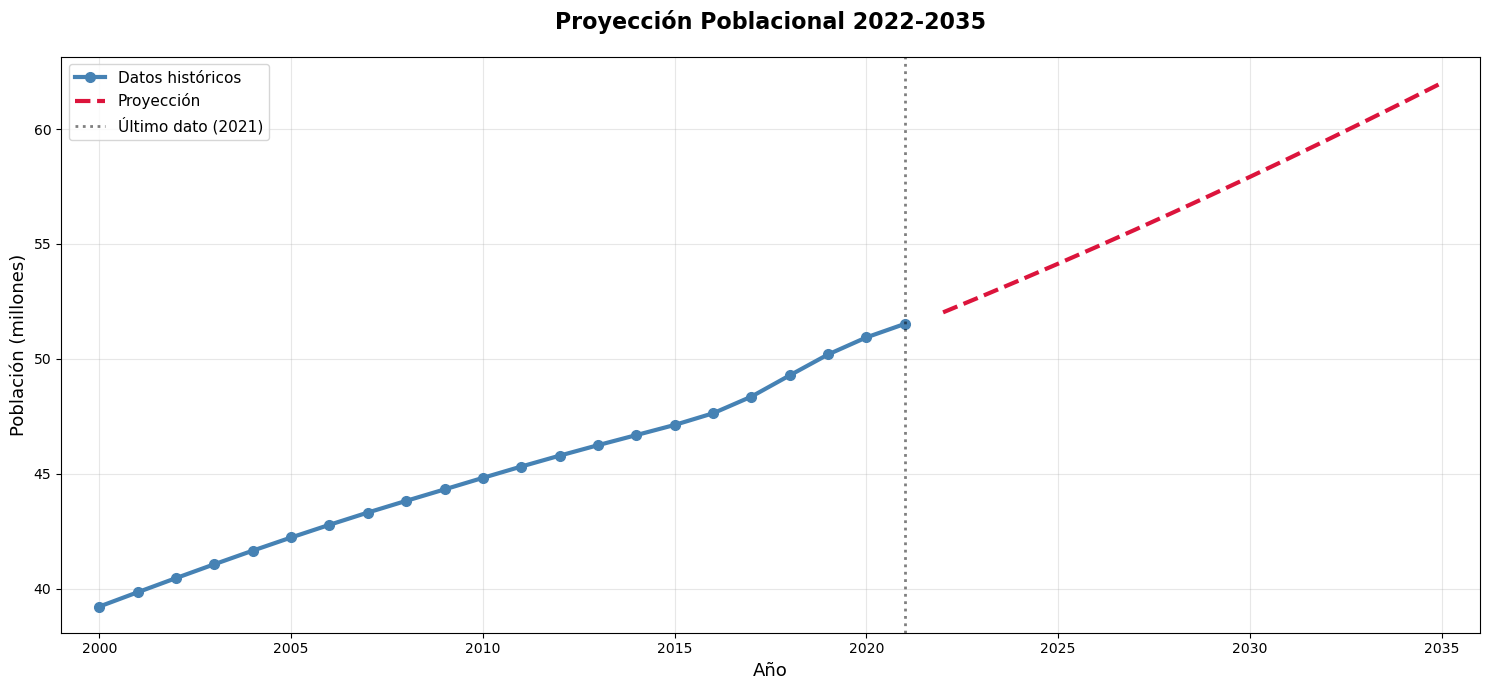

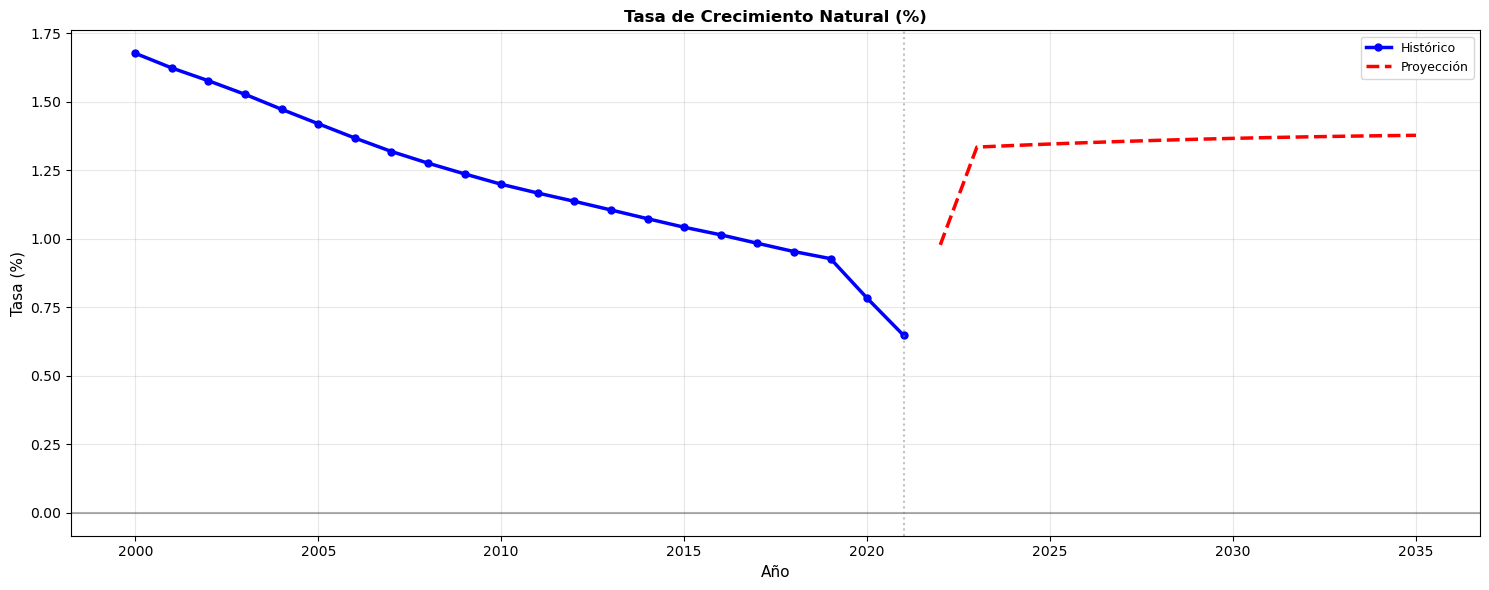

In [26]:
# ============================================
# VISUALIZACIONES
# ============================================

# Gráfico 1: Proyección poblacional
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_col["Year"], df_col["Population"] / 1e6,
        marker="o", linewidth=3, label="Datos históricos",
        color="steelblue", markersize=7)

ax.plot(df_future["Year"], df_future["Population"] / 1e6,
        linewidth=3, label="Proyección",
        color="crimson", linestyle="--")

ax.axvline(x=last_year, color="black", linestyle=":", linewidth=2,
           label=f"Último dato ({last_year})", alpha=0.5)

ax.set_title("Proyección Poblacional 2022-2035",
             fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Año", fontsize=13)
ax.set_ylabel("Población (millones)", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(df_col["Year"].min() - 1, df_future["Year"].max() + 1)

plt.tight_layout()
plt.show()

# Gráfico 2: Tasas de crecimiento
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_col["Year"], df_col["Natural_Growth_Rate"],
        marker="o", linewidth=2.5, label="Histórico",
        color="blue", markersize=5)

ax.plot(df_future["Year"], df_future["Natural_Growth"],
        linewidth=2.5, linestyle="--", label="Proyección", color="red")

ax.axhline(y=0, color="black", linewidth=1.5, linestyle="-", alpha=0.3)
ax.axvline(x=last_year, color="gray", linestyle=":", alpha=0.5)
ax.set_title("Tasa de Crecimiento Natural (%)",
              fontweight="bold", fontsize=12)
ax.set_xlabel("Año", fontsize=11)
ax.set_ylabel("Tasa (%)", fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
import joblib
import os

# Crear directorio para los modelos si no existe
models_dir = 'modelo'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Guardar únicamente el modelo de proyección poblacional
population_model_path = os.path.join(models_dir, 'population_model.joblib')
joblib.dump(pop_model, population_model_path)

# Opcional: guardar un bundle con componentes básicos (poly + regressor) por compatibilidad
population_bundle_path = os.path.join(models_dir, 'population_model_bundle.joblib')
population_bundle = {
    'poly': pop_model.poly,
    'regressor': pop_model.model,
    'last_year': pop_model.last_year,
    'last_pop': pop_model.last_pop
}
joblib.dump(population_bundle, population_bundle_path)

['modelo\\population_model_bundle.joblib']

In [29]:
import joblib
import os
import numpy as np
import pandas as pd

# Celda de verificación: cargar el modelo guardado y el bundle, predecir y mostrar resultados
print("VERIFICACIÓN: carga y predicción del modelo guardado")
models_dir = 'modelo'

# 1) Intentar cargar la instancia del modelo (requiere la clase definida en este notebook)
try:
    pop_model_loaded = joblib.load(os.path.join(models_dir, 'population_model.joblib'))
    print(f"Cargado 'population_model.joblib' desde {models_dir}")
    df_check = pop_model_loaded.predict(end_year=2035)
    print('\nProyecciones (últimos 5 años) desde instancia cargada:')
    print(df_check.tail(5))
except Exception as e:
    print("No fue posible cargar 'population_model.joblib' (la clase debe estar disponible). Error:", e)

# 2) Intentar cargar el bundle (más robusto para otros entornos)
try:
    bundle = joblib.load(os.path.join(models_dir, 'population_model_bundle.joblib'))
    print(f"\nCargado 'population_model_bundle.joblib' desde {models_dir}")

    poly = bundle['poly']
    reg = bundle['regressor']
    last_year = int(bundle['last_year'])
    last_pop = float(bundle['last_pop'])

    # Reconstruir una versión ligera de la lógica de predicción
    class _TempProj:
        def __init__(self, poly, reg, last_year, last_pop):
            self.poly = poly
            self.model = reg
            self.last_year = int(last_year)
            self.last_pop = float(last_pop)

        def predict(self, start_year=None, end_year=2035):
            if start_year is None:
                start_year = self.last_year + 1
            years = np.array(list(range(start_year, end_year + 1))).reshape(-1, 1)
            preds = self.model.predict(self.poly.transform(years))
            df = pd.DataFrame({'Year': years.flatten(), 'Population': preds})
            # calcular crecimiento natural aproximado
            cur = self.last_pop
            ng = []
            for p in df['Population']:
                ng.append((p - cur) / cur * 100)
                cur = p
            df['Natural_Growth'] = ng
            return df

    temp = _TempProj(poly, reg, last_year, last_pop)
    df_bundle_pred = temp.predict(end_year=2035)
    print('\nProyecciones (últimos 5 años) desde bundle:')
    print(df_bundle_pred.tail(5))
except Exception as e:
    print("No fue posible cargar 'population_model_bundle.joblib'. Error:", e)

# 3) Si df_future existe en memoria, mostrar una comparación breve
try:
    print('\nComparación rápida con df_future en memoria (si está disponible):')
    display_columns = ['Year', 'Population']
    compare = df_future.merge(df_bundle_pred[['Year', 'Population']], on='Year', how='inner', suffixes=('_df_future', '_bundle'))
    print(compare.tail(5))
except Exception:
    pass

print('\nVERIFICACIÓN COMPLETA')

VERIFICACIÓN: carga y predicción del modelo guardado
Cargado 'population_model.joblib' desde modelo

Proyecciones (últimos 5 años) desde instancia cargada:
    Year    Population  Natural_Growth
9   2031  5.871089e+07        1.368905
10  2032  5.951609e+07        1.371463
11  2033  6.033365e+07        1.373668
12  2034  6.116355e+07        1.375532
13  2035  6.200582e+07        1.377068

Cargado 'population_model_bundle.joblib' desde modelo

Proyecciones (últimos 5 años) desde bundle:
    Year    Population  Natural_Growth
9   2031  5.871089e+07        1.368905
10  2032  5.951609e+07        1.371463
11  2033  6.033365e+07        1.373668
12  2034  6.116355e+07        1.375532
13  2035  6.200582e+07        1.377068

Comparación rápida con df_future en memoria (si está disponible):
    Year  Population_df_future  Natural_Growth  Population_bundle
9   2031          5.871089e+07        1.368905       5.871089e+07
10  2032          5.951609e+07        1.371463       5.951609e+07
11  2033   